# Preprocessing

In [1]:
import os
import sys
import cv2
from pathlib import Path
import re
#import shutil
#import random
#from shutil import copyfile
import numpy as np

import matplotlib.pyplot as plt

# sklearn tools
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report


# tf tools
from tensorflow.keras.datasets import cifar10 #Our data
from tensorflow.keras.models import Sequential #Our Model
from tensorflow.keras.layers import (Conv2D, #Our layers
                                     MaxPooling2D, 
                                     Activation, 
                                     Flatten, 
                                     Dense)
from tensorflow.keras.utils import plot_model #Plotting 
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

import warnings
warnings.filterwarnings('ignore')

## FInd and create labels

In [2]:
#Path to training folder with painters
training_dir = os.path.join("..", "data", "small_training")
#Names as a string
label_names = []
#Training labels
trainY = []
#Counter variable
i = 0
#For each folder in the training data
for folder in Path(training_dir).glob("*"):
    #Find painters name
    painter = re.findall(r"(?!.*/).+", str(folder))
    #Append the painters names to the list "label_names"
    label_names.append(painter[0])
    #For each image in the folder
    for img in folder.glob("*"):
        #append the folder index (e.g. the label)
        trainY.append(i)
    #Increase counter by 1    
    i +=1 
    

In [3]:
#Path to test folder with painters
test_dir = os.path.join("..", "data", "small_validation")  
#Test labels
testY = []  
#Counter
i = 0
#For each folder in the test data
for folder in Path(test_dir).glob("*"):
    #For each image in the folder
    for img in folder.glob("*"):
        #Aooend the folder index (e.g. the label)
        testY.append(i)
    #Increase by 1
    i +=1   

In [4]:
#Binariser
lb = LabelBinarizer()
#Transform labels 0-9 into binary labels
trainY = lb.fit_transform(trainY)
testY = lb.fit_transform(testY)

## Resize images

In [5]:
#Function for resizing images and converting it to value between zero and 1
def resize_imgs(folder_path, dimensions):
    #List of image sizes
    images = []
    #Folder  each folder in training data
    for folder in Path(folder_path).glob("*"):
        # For each file in the folder
        for image in Path(folder).glob("*"):
            #read image
            image = cv2.imread(str(image))
            #resize image
            image = cv2.resize(image, dimensions, interpolation = cv2.INTER_AREA)
            #append image to array and convert it to a value between 0 and 1
            images.append(image.astype("float")/255.)
    return images

In [6]:
# Rezise training data
# path to training data
filepath_training = os.path.join("..", "data", "training")
# Create training data
trainX = resize_imgs(filepath_training, (120, 120))

# Resize validation data
# Path to validation data
filepath_validation = os.path.join("..", "data", "validation")
#Create test data
testX =resize_imgs(filepath_validation, (120,120))



In [7]:
#Convert data to numpy arrays
testX = np.array(testX)
trainX = np.array(trainX)

## Modelling

In [8]:
def plot_history(H, epochs):
    # visualize performance
    plt.style.use("fivethirtyeight")
    fig = plt.figure()
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig("../output/performance.png")

In [9]:
# define model
model = Sequential()

# first set of CONV => RELU => POOL

#Conv
model.add(Conv2D(32, (3, 3), 
                 padding="same", 
                 input_shape= (120, 120, 3)))
#Relu
model.add(Activation("relu"))
#Pool
model.add(MaxPooling2D(pool_size=(2, 2), 
                       strides=(2, 2)))

# second set of CONV => RELU => POOL
#Conv
model.add(Conv2D(50, (5, 5), 
                 padding="same"))
#Relu
model.add(Activation("relu"))
#Pool
model.add(MaxPooling2D(pool_size=(2, 2), 
                       strides=(2, 2)))

# FC => RELU
#flatten
model.add(Flatten())
#Add layer
model.add(Dense(500))
#Relu
model.add(Activation("relu"))

# softmax classifier
#layer
model.add(Dense(10))
#Activation
model.add(Activation("softmax"))

In [10]:
#Our optimizer with the stochastic descent (our learning rate is here 0.1 it can be between 0.001 and 0.01)
opt = SGD(lr=0.01)
model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

In [11]:
#Create a summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 120, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 120, 120, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 50)        40050     
_________________________________________________________________
activation_1 (Activation)    (None, 60, 60, 50)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 50)        0         
_________________________________________________________________
flatten (Flatten)            (None, 45000)             0

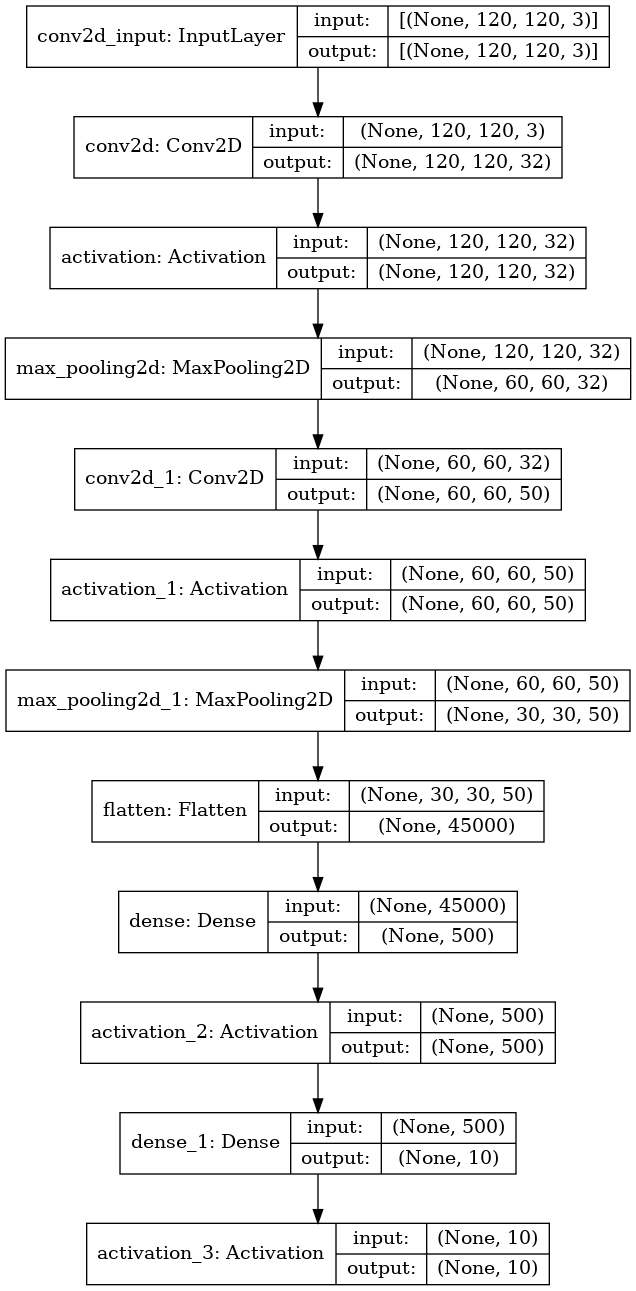

In [12]:
plot_model(model, to_file = "../output/model_architecture.png", show_shapes=True, show_layer_names=True)

In [13]:
# train model
H = model.fit(trainX, trainY, 
              validation_data=(testX, testY), 
              batch_size=32,
              epochs=20,
              verbose=1)

ValueError: Data cardinality is ambiguous:
  x sizes: 0
  y sizes: 400
Make sure all arrays contain the same number of samples.

In [ ]:
#Plot performance pr. epoch
plot_history(H,20)

In [ ]:
#Print classification report
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=label_names))

In [ ]:
predictions = model.predict(testX[54], batch_size=32)